In [81]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import math
import pickle
import time
from tqdm import tqdm, tqdm_notebook

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import cross_val_score, KFold, train_test_split

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, \
                            classification_report, log_loss

from multi_agent_simulator import BiddingAgent, BiddingEnvironment, BidStrategy

from imblearn.metrics import classification_report_imbalanced

from sklearn.linear_model import LogisticRegression

import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
pd.set_option('display.max_columns', 100)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def memory(df):
    print("Memory usage of the dataframe is {:.2f} MB".format(
        df.memory_usage().sum() / 1024**2))
    
    
def entropy(df, base = 2):
    """ Calculate the entropy for every column in a df"""
    
    entropy = {}
    
    for column in df.columns:
        prob = df[column].value_counts(normalize=True, sort=False)
        
        entropy[column] = -(prob * np.log(prob)/np.log(base)).sum()
        
    return pd.Series(entropy).sort_values(ascending=False)

# Train LR model

Download pickle resampled data from:
https://liveuclac-my.sharepoint.com/:u:/r/personal/ucabjcv_ucl_ac_uk/Documents/resampled?csf=1&e=swcNPL
*It contains a exsension less file, you might need to remove it if you find troubles using it*

contains tuple(X_resampled, y_resampled)


*alternatively download the trained LR model here:*
https://liveuclac-my.sharepoint.com/:u:/r/personal/ucabjcv_ucl_ac_uk/Documents/lr_model?csf=1&e=5j4WJX

In [75]:
validation = pd.read_hdf('preprocessed.h5', 'validation')
X_resampled, y_resampled = pickle.load(open( "resampled", "rb" ))

y_validate_true = validation['click'].values
X_validate = validation.drop(columns=['click', 'payprice'])

test = pd.read_hdf('preprocessed.h5', 'test')

In [53]:
%%time
random_seed = 4448

lr = LogisticRegression(solver='lbfgs', max_iter=500, C=1, n_jobs=-1, random_state=1, class_weight='balanced') 
lr.fit(X_resampled, y_resampled)

# export model
pickle.dump(lr, open( "lr_model", "wb" ))

print('done')

done
CPU times: user 1.97 s, sys: 4.68 s, total: 6.65 s
Wall time: 2min 30s


In [21]:
lr = pickle.load(open( "lr_model", "rb" ))

## Evaluate LR model on validation

In [57]:
y_validate_class = lr.predict(X_validate)
print(classification_report_imbalanced(y_validate_true, y_validate_class, target_names=['no click', 'click']))
print('ROC AUC:\t{:.5f}'.format(roc_auc_score(y_validate_true, y_validate_class)))
print("Log loss:\t{:.5f}".format(log_loss(y_validate_true, y_validate_class)))

y_validate_prob = lr.predict_proba(X_validate)
print('Log loss\t{:.5f}'.format(log_loss(y_validate_true, y_validate_prob)))
print('ROC AUC\t{:.5f}'.format(roc_auc_score(y_validate_true, y_validate_prob[:,1])))
    
print('done')

                   pre       rec       spe        f1       geo       iba       sup

   no click       1.00      1.00      0.17      1.00      0.42      0.19    303723
      click       0.04      0.17      1.00      0.06      0.42      0.16       202

avg / total       1.00      1.00      0.17      1.00      0.42      0.19    303925

ROC AUC:	0.58508
Log loss:	0.12626
Log loss	0.02417
ROC AUC	0.80164
done


## Linear bidding

In [66]:
%%time
# set bidding environment
environment = BiddingEnvironment(validation.copy())

# get pCTR
pCTR_val = lr.predict_proba(X_validate)[:, 1]

no_click, click = np.bincount(y_validate_true)
avgCTR = click / (no_click + click)

bid_range = np.arange(3.4, 3.8, 0.02)
bid_range_wide = np.arange(1, 5, .5)
bid_range = np.concatenate((bid_range, bid_range_wide), axis=0)

results_linear = {}

# find optimal base_bid
for base_bid in tqdm(bid_range):
    agent = BiddingAgent(6250*1000, environment)
    bids = BidStrategy.linear_bidding(pCTR_val, avgCTR, base_bid)

    agent.simulate(bids)
    results_linear[base_bid] = agent.statistics()
    
results_linear = pd.DataFrame(results_linear).T

print('done')

100%|██████████| 28/28 [01:35<00:00,  3.46s/it]

done
CPU times: user 1min 44s, sys: 7.78 s, total: 1min 52s
Wall time: 1min 56s


In [67]:
results_linear.sort_values('clicks', ascending=False).head(5)

,CTR,aCPC,aCPM,budget_left,clicks,impressions,lost,spend
3.52,0.001290,41.520295,53.548606,63476.0,149.0,115531.0,188394.0,6186524.0
3.54,0.001285,41.721557,53.605871,33488.0,149.0,115967.0,187958.0,6216512.0
3.56,0.001280,41.899101,53.645250,7034.0,149.0,116375.0,187550.0,6242966.0
3.60,0.001281,41.946309,53.733396,0.0,149.0,116315.0,186712.0,6250000.0
3.46,0.001295,41.227041,53.396827,148398.0,148.0,114269.0,189656.0,6101602.0


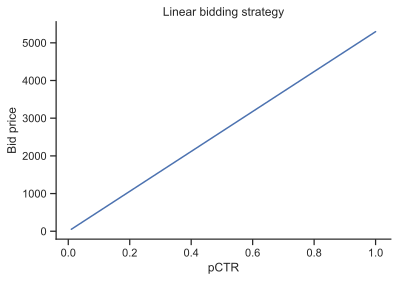

In [68]:
no_click, click = np.bincount(y_validate_true)
avgCTR = click / (no_click + click)

x = np.linspace(1e-2, 1)
y = BidStrategy.linear_bidding(x, avgCTR, 3.52)

plt.plot(x,y)
sns.despine()
plt.title('Linear bidding strategy')
plt.ylabel('Bid price')
plt.xlabel('pCTR')
plt.show()

### Apply linear strategy pCTR to test set

In [82]:
%%time
X_test = test.drop(columns=['click', 'payprice'])
y_test_prob = lr.predict_proba(X_test)
avgCTR = click / (no_click + click)

pCTR_test = y_test_prob[:, 1]

bids = BidStrategy.linear_bidding(pCTR_test, avgCTR, 3.52)

# get bid id's
test_raw = pd.read_csv('../we_data/test.csv')

# export to file
df_bids = pd.DataFrame(np.round(bids,1), index=test_raw['bidid'].values, columns=['bidprice'])
df_bids.index.name = 'bidid'
df_bids = df_bids.reset_index()

file = 'bid_attemnt_lr_linear_{}.csv'.format(time.strftime('%Y-%m-%d_%H:%M:%S'))

df_bids.to_csv(file, index=False)

CPU times: user 11.9 s, sys: 8.1 s, total: 20 s
Wall time: 22 s


## ORTB1 bidding

In [69]:
%%time
lamda_range = np.linspace(1e-6, 1e-4, num=50) #50
const_range = np.arange(10, 100, 5) #5
parameter_grid = [(x,i) for x in const_range for i in lamda_range]

results_ortb1 = {}

# find optimal base_bid
for const, lamda in tqdm(parameter_grid):
    index = (const, lamda)
    
    agent = BiddingAgent(6250*1000, environment)
    bids = BidStrategy.ortb1(pCTR_val, const, lamda)

    agent.simulate(bids)
    results_ortb1[index] = agent.statistics()
    
results_ortb1 = pd.DataFrame(results_ortb1).T
print('done')

100%|██████████| 900/900 [2:14:08<00:00,  3.93s/it]    

done
CPU times: user 57min 51s, sys: 19.4 s, total: 58min 11s
Wall time: 2h 14min 8s


In [76]:
results_ortb1.sort_values('clicks', ascending=False).head(5)

,,CTR,aCPC,aCPM,budget_left,clicks,impressions,lost,spend
15,0.000025,0.001145,40.567258,46.461041,124344.0,151.0,131845.0,172080.0,6125656.0
45,0.000047,0.001177,41.394893,48.735805,40766.0,150.0,127406.0,176519.0,6209234.0
50,0.000049,0.001179,41.566873,48.994044,14969.0,150.0,127261.0,176664.0,6235031.0
30,0.000039,0.001171,40.720067,47.683810,141990.0,150.0,128094.0,175831.0,6108010.0
65,0.000056,0.001196,41.357307,49.469674,46404.0,150.0,125402.0,178523.0,6203596.0


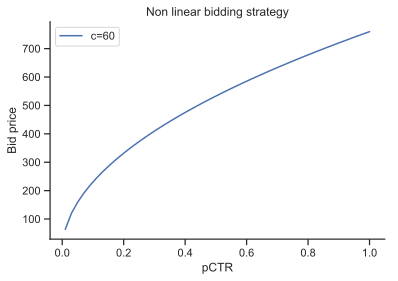

In [78]:
x = np.linspace(1e-2, 1)
y = BidStrategy.ortb1(x, 15, 0.000025)

plt.plot(x,y, label='c=60')
sns.despine()
plt.title('Non linear bidding strategy')
plt.ylabel('Bid price')
plt.xlabel('pCTR')
plt.legend()
plt.show()

### Apply ORTB1 strategy pCTR to test set

In [ ]:
%%time
X_test = test.drop(columns=['click', 'payprice'])
y_test_prob = lr.predict_proba(X_test)

pCTR = y_test_prob[:, 1]

bids = BidStrategy.ortb1(pCTR, 55, 0.000053)

# get bid id's
test_raw = pd.read_csv('../we_data/test.csv')

# export to file
df_bids = pd.DataFrame(
    np.round(bids, 1), index=test_raw['bidid'].values, columns=['bidprice'])
df_bids.index.name = 'bidid'
df_bids = df_bids.reset_index()

file = 'bid_attemnt_lr_ortb1_{}.csv'.format(time.strftime('%Y-%m-%d_%H:%M:%S'))

df_bids.to_csv(file, index=False)

CPU times: user 11.9 s, sys: 8.29 s, total: 20.2 s
Wall time: 24.3 s


# ORTB2 bidding

In [72]:
%%time
lamda_range = np.linspace(1e-6, 1e-4, num=50) #50
const_range = np.arange(10, 100, 5) #5
parameter_grid = [(x,i) for x in const_range for i in lamda_range]

results_ortb2 = {}

# find optimal base_bid
for const, lamda in tqdm(parameter_grid):
    index = (const, lamda)
    
    agent = BiddingAgent(6250*1000, environment)
    bids = BidStrategy.ortb2(pCTR_val, const, lamda)

    agent.simulate(bids)
    results_ortb2[index] = agent.statistics()
    
results_ortb2 = pd.DataFrame(results_ortb2).T
print('done')

100%|██████████| 900/900 [3:50:41<00:00,  3.85s/it]     


done
CPU times: user 1h 16min 8s, sys: 25.4 s, total: 1h 16min 34s
Wall time: 3h 50min 41s


In [77]:
results_ortb2.sort_values('clicks', ascending=False).head(5)

CTR       aCPC       aCPM  budget_left  clicks  impressions  \
90 0.000090  0.001205  40.821755  49.179698      85915.0   151.0     125338.0   
80 0.000086  0.001193  40.673693  48.509998     148946.0   150.0     125769.0   
   0.000084  0.001177  41.370987  48.708806      44352.0   150.0     127403.0   
65 0.000074  0.001152  41.449940  47.732857      32509.0   150.0     130256.0   
60 0.000070  0.001143  41.422600  47.332541      36610.0   150.0     131271.0   

                 lost      spend  
90 0.000090  178587.0  6164085.0  
80 0.000086  178156.0  6101054.0  
   0.000084  176522.0  6205648.0  
65 0.000074  173669.0  6217491.0  
60 0.000070  172654.0  6213390.0

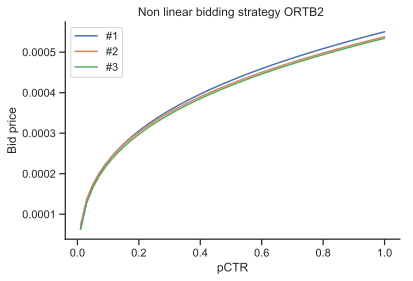

In [74]:
x = np.linspace(1e-2, 1)
y = BidStrategy.ortb2(x, 0.000090,90)
y2 = BidStrategy.ortb2(x, 0.000086,80)
y3 = BidStrategy.ortb2(x, 0.000086,90)

plt.plot(x,y, label='#1')
plt.plot(x, y2, label='#2')
plt.plot(x, y3, label='#3')
sns.despine()
plt.title('Non linear bidding strategy ORTB2 ')
plt.ylabel('Bid price')
plt.xlabel('pCTR')
plt.legend()
plt.show()